In [1]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [8]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
pd.__version__

'0.23.4'

# 读取数据并转化JSON格式

In [3]:
def load_df(csv_path='F:\\kaggle\\GAR\\input\\train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [177]:
%%time
train_df = load_df()
test_df = load_df("F:\\kaggle\\GAR\\input\\test.csv")

Loaded train.csv. Shape: (903653, 55)
Loaded test.csv. Shape: (804684, 53)
Wall time: 5min 55s


In [20]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Izmir,not available in demo dataset,Asia,Turkey,not available in demo dataset,not available in demo dataset,(not set),ttnet.com.tr,not available in demo dataset,Izmir,Western Asia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Oceania,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,Australasia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Madrid,not available in demo dataset,Europe,Spain,not available in demo dataset,not available in demo dataset,(not set),unknown.unknown,not available in demo dataset,Community of Madrid,Southern Europe,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not a

In [26]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 55 columns):
channelGrouping                                      903653 non-null object
date                                                 903653 non-null int64
fullVisitorId                                        903653 non-null object
sessionId                                            903653 non-null object
socialEngagementType                                 903653 non-null object
visitId                                              903653 non-null int64
visitNumber                                          903653 non-null int64
visitStartTime                                       903653 non-null int64
device.browser                                       903653 non-null object
device.browserSize                                   903653 non-null object
device.browserVersion                                903653 non-null object
device.deviceCategory                                9036

# 查看数据分布

In [185]:
def find_missing(data):
    # number of missing values
    count_missing = data.isnull().sum().values
    # total records
    total = data.shape[0]
    # percentage of missing
    ratio_missing = count_missing/total
    # return a dataframe to show: feature name, # of missing and % of missing
    return pd.DataFrame(data={'missing_count':count_missing, 'missing_ratio':ratio_missing}, index=data.columns.values)
train_missing = find_missing(train_df)
test_missing = find_missing(test_df)


In [186]:
missing=pd.merge(train_missing[train_missing['missing_ratio']>0][['missing_ratio']],
                 test_missing[test_missing['missing_ratio']>0][['missing_ratio']],
                 left_index=True,right_index=True,how='outer')
missing.columns=['train_missing','test_missing']
missing.sort_values(by='train_missing',ascending=False)

,train_missing,test_missing
trafficSource.campaignCode,0.999999,NaN
trafficSource.adContent,0.987887,0.933153
totals.transactionRevenue,0.987257,NaN
trafficSource.adwordsClickInfo.adNetworkType,0.976252,0.933124
trafficSource.adwordsClickInfo.isVideoAd,0.976252,0.933124
trafficSource.adwordsClickInfo.page,0.976252,0.933124
trafficSource.adwordsClickInfo.slot,0.976252,0.933124
trafficSource.adwordsClickInfo.gclId,0.976140,0.933064
trafficSource.isTrueDirect,0.696781,0.676254
trafficSource.referralPath,0.633774,0.707558


可以看出trafficSource里好几项都是缺失在97.5%以上的，验证集中缺失在93%以上

# 交易金额处理

In [187]:
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float')
gdf = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

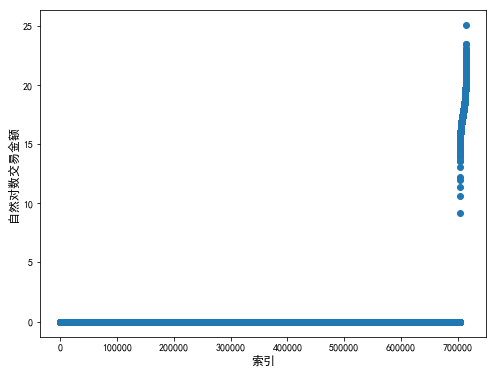

In [188]:
plt.figure(figsize=(8,6))
plt.scatter(range(gdf.shape[0]),np.sort(np.log1p(gdf["totals.transactionRevenue"].values)))
plt.xlabel('索引', fontsize=12)
plt.ylabel('自然对数交易金额', fontsize=12)
plt.show()

可以看出只有极少数的人有非零交易金额

In [10]:
nzi = pd.notnull(train_df["totals.transactionRevenue"]).sum() #非零金额数量
nzr = (gdf["totals.transactionRevenue"]>0).sum()#非零交易人数
print("Number of instances in train set with non-zero revenue : ", nzi, " and ratio is : ", nzi / train_df.shape[0])
print("Number of unique customers with non-zero revenue : ", nzr, "and the ratio is : ", nzr / gdf.shape[0])

Number of instances in train set with non-zero revenue :  11515  and ratio is :  0.0127427231470487
Number of unique customers with non-zero revenue :  9996 and the ratio is :  0.013996726255903731


In [11]:
print("Number of unique visitors in train set : ",train_df.fullVisitorId.nunique(), " out of rows : ",train_df.shape[0])
print("Number of unique visitors in test set : ",test_df.fullVisitorId.nunique(), " out of rows : ",test_df.shape[0])
print("Number of common visitors in train and test set : ",len(set(train_df.fullVisitorId.unique()).intersection(set(test_df.fullVisitorId.unique())) ))

Number of unique visitors in train set :  714167  out of rows :  903653
Number of unique visitors in test set :  617242  out of rows :  804684
Number of common visitors in train and test set :  7679


# 其余特征情况

## 全是唯一值的列

In [12]:
const_cols = [c for c in train_df.columns if train_df[c].nunique(dropna=False)==1 ]
const_cols

['socialEngagementType',
 'device.browserSize',
 'device.browserVersion',
 'device.flashVersion',
 'device.language',
 'device.mobileDeviceBranding',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.operatingSystemVersion',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters']

上述所有列都可以删除

## 设备信息

In [189]:
def horizontal_bar_chart(cnt_srs,color):
    trace=go.Bar(
        y=cnt_srs.index[::-1],
        x=cnt_srs.values[::-1],
        showlegend=False,
        orientation='h',
        marker=dict(
            color=color,
        ),
    )
    return trace

In [40]:
#Device Browser
cnt_srs = train_df.groupby('device.browser')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]

cnt_srs = cnt_srs.sort_values(by="count", ascending=False)

trace1=horizontal_bar_chart(cnt_srs['count'].head(10),'rgba(50, 171, 96, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs.sort_values(by="count of non-zero revenue", ascending=False)["count of non-zero revenue"].head(10), 'rgba(50, 171, 96, 0.6)')
trace3 = horizontal_bar_chart(cnt_srs.sort_values(by="mean", ascending=False)["mean"].head(10), 'rgba(50, 171, 96, 0.6)')

#Device Category
cnt_srs = train_df.groupby('device.deviceCategory')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]

cnt_srs = cnt_srs.sort_values(by="count", ascending=False)

trace4=horizontal_bar_chart(cnt_srs['count'].head(10),'rgba(70, 171, 96, 0.6)')
trace5 = horizontal_bar_chart(cnt_srs.sort_values(by="count of non-zero revenue", ascending=False)["count of non-zero revenue"].head(10), 'rgba(50, 171, 96, 0.6)')
trace6 = horizontal_bar_chart(cnt_srs.sort_values(by="mean", ascending=False)["mean"].head(10), 'rgba(70, 171, 96, 0.6)')

#Device operatingSystem
cnt_srs = train_df.groupby('device.operatingSystem')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]

cnt_srs = cnt_srs.sort_values(by="count", ascending=False)

trace7=horizontal_bar_chart(cnt_srs['count'].head(10),'rgba(70, 171, 96, 0.6)')
trace8 = horizontal_bar_chart(cnt_srs.sort_values(by="count of non-zero revenue", ascending=False)["count of non-zero revenue"].head(10), 'rgba(50, 171, 96, 0.6)')
trace9 = horizontal_bar_chart(cnt_srs.sort_values(by="mean", ascending=False)["mean"].head(10), 'rgba(70, 171, 96, 0.6)')

In [41]:
# Creating two subplots
fig = tools.make_subplots(rows=3, cols=3, vertical_spacing=0.04, 
                          subplot_titles=["Device Browser - Count", "Device Browser - Non-zero Revenue Count", "Device Browser - Mean Revenue",
                                          "Device Category - Count",  "Device Category - Non-zero Revenue Count", "Device Category - Mean Revenue", 
                                          "Device OS - Count", "Device OS - Non-zero Revenue Count", "Device OS - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)

fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Device Plots")

py.iplot(fig,filename='device-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]
[ (3,1) x7,y7 ]  [ (3,2) x8,y8 ]  [ (3,3) x9,y9 ]



（1）对于使用的浏览器，Chrome最多，但平均下来火狐的交易金额最多

（2）设备类型是桌面端使用的较多，且交易金额也比较高

（3）操作系统非零交易中Mac要高于Windows，但Windows总体访问量要高，平均交易金额也是Windows大于Mac，但Chrome的最高

## 时间序列

In [25]:
import datetime 

def scatter_plot(cnt_srs,color):
    trace = go.Scatter(
        x=cnt_srs.index[::-1],
        y=cnt_srs.values[::-1],
        showlegend=False,
        marker=dict(
            color=color,
        ),
    )
    return trace

In [27]:
train_df['date'] = train_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))

In [30]:
cnt_srs = train_df.groupby('date')['totals.transactionRevenue'].agg(['size', 'count'])
cnt_srs.columns = ["count", "count of non-zero revenue"]
cnt_srs = cnt_srs.sort_index()

trace1 = scatter_plot(cnt_srs["count"], 'red')
trace2 = scatter_plot(cnt_srs["count of non-zero revenue"], 'blue')

In [31]:
fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.08,
                          subplot_titles=["Date - Count", "Date - Non-zero Revenue count"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 2, 1)
fig['layout'].update(height=800, width=800, paper_bgcolor='rgb(233,233,233)', title="Date Plots")
py.iplot(fig, filename='date-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]



可以看出访问量在11月和12月有峰值，且产生交易的访问量不在11月份有峰值。下图为测试集，可见两个数据集时间不重合，并且在12月，测试集的访问量也出现了峰值。

In [32]:
test_df['date'] = test_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
cnt_srs = test_df.groupby('date')['fullVisitorId'].size()


trace = scatter_plot(cnt_srs, 'red')

layout = go.Layout(
    height=400,
    width=800,
    paper_bgcolor='rgb(233,233,233)',
    title='Dates in Test set'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="ActivationDate")

## 地理因素

In [39]:
# Continent
cnt_srs = train_df.groupby('geoNetwork.continent')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(58, 71, 80, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs.sort_values(by='count of non-zero revenue',ascending=False)["count of non-zero revenue"].head(10), 'rgba(58, 71, 80, 0.6)')
trace3 = horizontal_bar_chart(cnt_srs.sort_values(by='mean',ascending=False)["mean"].head(10), 'rgba(58, 71, 80, 0.6)')

# Sub-continent
cnt_srs = train_df.groupby('geoNetwork.subContinent')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"], 'orange')
trace5 = horizontal_bar_chart(cnt_srs.sort_values(by='count of non-zero revenue',ascending=False)["count of non-zero revenue"], 'orange')
trace6 = horizontal_bar_chart(cnt_srs.sort_values(by='mean',ascending=False)["mean"], 'orange')

# Network domain
cnt_srs = train_df.groupby('geoNetwork.networkDomain')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace7 = horizontal_bar_chart(cnt_srs["count"].head(10), 'blue')
trace8 = horizontal_bar_chart(cnt_srs.sort_values(by='count of non-zero revenue',ascending=False)["count of non-zero revenue"].head(10), 'blue')
trace9 = horizontal_bar_chart(cnt_srs.sort_values(by='mean',ascending=False)["mean"].head(10), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Continent - Count", "Continent - Non-zero Revenue Count", "Continent - Mean Revenue",
                                          "Sub Continent - Count",  "Sub Continent - Non-zero Revenue Count", "Sub Continent - Mean Revenue",
                                          "Network Domain - Count", "Network Domain - Non-zero Revenue Count", "Network Domain - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)

fig['layout'].update(height=1500, width=1200, paper_bgcolor='rgb(233,233,233)', title="Geography Plots")
py.iplot(fig, filename='geo-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]
[ (3,1) x7,y7 ]  [ (3,2) x8,y8 ]  [ (3,3) x9,y9 ]



可以看出访问量越多的地区发生的交易不一定越高。为啥非洲的交易量会那么多？

## 流量源

In [56]:
# Source
cnt_srs = train_df.groupby('trafficSource.source')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'green')
trace2 = horizontal_bar_chart(cnt_srs.sort_values(by="count of non-zero revenue", ascending=False)["count of non-zero revenue"].head(10), 'green')
trace3 = horizontal_bar_chart(cnt_srs.sort_values(by="mean", ascending=False)["mean"].head(10), 'green')

# Medium
cnt_srs = train_df.groupby('trafficSource.medium')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"], 'purple')
trace5 = horizontal_bar_chart(cnt_srs.sort_values(by="count of non-zero revenue", ascending=False)["count of non-zero revenue"], 'purple')
trace6 = horizontal_bar_chart(cnt_srs.sort_values(by="mean", ascending=False)["mean"], 'purple')



# Creating two subplots
fig = tools.make_subplots(rows=2, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Traffic Source - Count", "Traffic Source - Non-zero Revenue Count", "Traffic Source - Mean Revenue",
                                          "Traffic Source Medium - Count",  "Traffic Source Medium - Non-zero Revenue Count", "Traffic Source Medium - Mean Revenue"
                                          ])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)

fig['layout'].update(height=1000, width=1200, paper_bgcolor='rgb(233,233,233)', title="Traffic Source Plots")
py.iplot(fig, filename='traffic-source-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]



从流量来源图可以看出YOUTUBE的流量很多，但消费很少，而且google邮箱的流量消费均值较高；

流量媒体中，referral的消费量超过了organic

## 来访者主页

In [193]:
# Page views
cnt_srs = train_df.groupby('totals.pageviews')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(60), 'cyan')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(60), 'cyan')
trace5 = horizontal_bar_chart(cnt_srs["mean"].head(60), 'cyan')

# Hits
cnt_srs = train_df.groupby('totals.hits')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", 'mean']
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace3 = horizontal_bar_chart(cnt_srs["count"].head(60), 'black')
trace4 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(60), 'black')
trace6 = horizontal_bar_chart(cnt_srs["mean"].head(60), 'black')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Total Pageviews - Count", "Total Pageviews - Non-zero Revenue Count", "Total Pageviews - Mean Revenue",
                                          "Total Hits - Count",  "Total Hits - Non-zero Revenue Count", "Total Hits - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace5, 1, 3)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 2)
fig.append_trace(trace6, 2, 3)

fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Visitor Profile Plots")
py.iplot(fig, filename='visitor-profile-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]



可以看出主页访问量和点击量的趋势是基本一致的

## channelGrouping

In [178]:
print(len(train_df['channelGrouping'].value_counts()))

8


In [192]:
# channel grouping
cnt_srs = train_df.groupby('channelGrouping')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'cyan')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(60), 'cyan')
trace5 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'cyan')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=3, vertical_spacing=0.1, horizontal_spacing=0.15, 
                          subplot_titles=["channelGrouping - Count", "channelGrouping - Non-zero Revenue Count",
                                          "channelGrouping - Mean Revenue"])
                          
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace5, 1, 3)

fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="channelGrouping Plots")
py.iplot(fig, filename='channelGrouping-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]



channelGrouping是访问渠道，有8个分类，可能与Source.medium有一定联系

## visitNumber

In [196]:
print(len(train_df['visitNumber'].value_counts()))

384


In [203]:
# visit number
cnt_srs = train_df.groupby('visitNumber')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'cyan')
trace2 = horizontal_bar_chart(cnt_srs.sort_values(by="count of non-zero revenue", ascending=False)["count of non-zero revenue"].head(10), 'cyan')
trace5 = horizontal_bar_chart(cnt_srs.sort_values(by="mean", ascending=False)["mean"].head(10), 'cyan')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=3, vertical_spacing=0.1, horizontal_spacing=0.15, 
                          subplot_titles=["visitNumber - Count", "visitNumber - Non-zero Revenue Count",
                                          "visitNumber - Mean Revenue"])
                          
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace5, 1, 3)

fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="visitNumber Plots")
py.iplot(fig, filename='visitNumber-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]



可以看出非0交易的访问次数，1次的最多。但从平均消费来看，180次和243次的要多一些

## 时间序列date,visitStartTime进一步处理

### 将访问的时间换成日，星期几和小时

In [92]:
for df in [train_df, test_df]:
    df['date'] = pd.to_datetime(df['date'])
    df['sess_date_dow'] = df['date'].dt.dayofweek
    df['sess_date_hours'] = df['date'].dt.hour
    df['sess_date_dom'] = df['date'].dt.day

In [93]:
train_df.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,sess_date_dow,sess_date_hours,sess_date_dom
0,4,2016-09-02,1131660440785968503,1472830385,1.0,1.472830e+09,35,0,False,20,378,3,210,0,37454,193,21,1.0,1.0,1.0,1.0,0.0,62,3,59008,1,11,3,4,1,11,5,3196,208,4,0,2
1,4,2016-09-02,377306020877927890,1472880147,1.0,1.472880e+09,43,0,False,7,955,5,12,122,10098,482,1,1.0,1.0,1.0,1.0,0.0,62,3,59008,1,11,3,4,1,11,5,3196,208,4,0,2
2,4,2016-09-02,3895546263509774583,1472865386,1.0,1.472865e+09,35,0,False,20,475,4,185,0,38725,99,19,1.0,1.0,1.0,1.0,0.0,62,3,59008,1,11,3,4,1,11,5,3196,208,4,0,2
3,4,2016-09-02,4763447161404445595,1472881213,1.0,1.472881e+09,79,0,False,6,955,3,94,122,38725,482,16,1.0,1.0,1.0,1.0,0.0,62,3,59008,1,11,3,4,1,1607,5,3196,208,4,0,2
4,4,2016-09-02,27294437909732085,1472822600,2.0,1.472823e+09,35,1,True,1,955,4,217,122,38725,482,13,1.0,1.0,NaN,1.0,0.0,62,3,59008,1,11,3,4,0,11,5,3196,208,4,0,2


In [96]:
# day of week
cnt_srs = train_df.groupby('sess_date_dow')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(30), 'cyan')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(30), 'cyan')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(30), 'cyan')

# day of hours
cnt_srs = train_df.groupby('sess_date_hours')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", 'mean']
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"].head(30), 'black')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(30), 'black')
trace6 = horizontal_bar_chart(cnt_srs["mean"].head(30), 'black')

# day of month
cnt_srs = train_df.groupby('sess_date_dom')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", 'mean']
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace7 = horizontal_bar_chart(cnt_srs["count"].head(30), 'black')
trace8 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(30), 'black')
trace9 = horizontal_bar_chart(cnt_srs["mean"].head(30), 'black')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["day of week - Count", "day of week - Non-zero Revenue Count", "day of week - Mean Revenue",
                                          "date hours - Count",  "date hours - Non-zero Revenue Count", "date hours - Mean Revenue",
                                         "date of month - Count",  "date of month - Non-zero Revenue Count", "date of month - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)

fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Visits Date Plots")
py.iplot(fig, filename='vist-date-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]
[ (3,1) x7,y7 ]  [ (3,2) x8,y8 ]  [ (3,3) x9,y9 ]



可以看出date中hour没有数据，考虑从visitStartTime中获取

### 使用UTC时间 visitStartTime

In [158]:
for df in [train_df, test_df]:
    df['visitStartTime'] = pd.to_datetime(df['visitStartTime'],unit='s')
    df['sess_date_dow'] = df['visitStartTime'].dt.dayofweek
    df['sess_date_hours'] = df['visitStartTime'].dt.hour
    df['sess_date_dom'] = df['visitStartTime'].dt.day
    df['sess_date_mon'] = df['visitStartTime'].dt.month

In [159]:
train_df.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,sess_date_dow,sess_date_hours,sess_date_dom,sess_date_mon
0,4,2016-09-02,1131660440785968503,1472830385,1.0,2016-09-02 15:33:05,35,0,False,20,378,3,210,0,37454,193,21,1.0,1.0,1.0,1.0,0.0,62,3,59008,1,11,3,4,1,11,5,3196,208,4,15,2,9
1,4,2016-09-02,377306020877927890,1472880147,1.0,2016-09-03 05:22:27,43,0,False,7,955,5,12,122,10098,482,1,1.0,1.0,1.0,1.0,0.0,62,3,59008,1,11,3,4,1,11,5,3196,208,5,5,3,9
2,4,2016-09-02,3895546263509774583,1472865386,1.0,2016-09-03 01:16:26,35,0,False,20,475,4,185,0,38725,99,19,1.0,1.0,1.0,1.0,0.0,62,3,59008,1,11,3,4,1,11,5,3196,208,5,1,3,9
3,4,2016-09-02,4763447161404445595,1472881213,1.0,2016-09-03 05:40:13,79,0,False,6,955,3,94,122,38725,482,16,1.0,1.0,1.0,1.0,0.0,62,3,59008,1,11,3,4,1,1607,5,3196,208,5,5,3,9
4,4,2016-09-02,27294437909732085,1472822600,2.0,2016-09-02 13:23:20,35,1,True,1,955,4,217,122,38725,482,13,1.0,1.0,NaN,1.0,0.0,62,3,59008,1,11,3,4,0,11,5,3196,208,4,13,2,9


In [103]:
# day of week
cnt_srs = train_df.groupby('sess_date_dow')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(30), 'cyan')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(30), 'cyan')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(30), 'cyan')

# day of hours
cnt_srs = train_df.groupby('sess_date_hours')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", 'mean']
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"].head(30), 'black')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(30), 'black')
trace6 = horizontal_bar_chart(cnt_srs["mean"].head(30), 'black')

# day of month
cnt_srs = train_df.groupby('sess_date_dom')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", 'mean']
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace7 = horizontal_bar_chart(cnt_srs["count"].head(30), 'violet')
trace8 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(30), 'violet')
trace9 = horizontal_bar_chart(cnt_srs["mean"].head(30), 'violet')

# month
cnt_srs = train_df.groupby('sess_date_mon')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", 'mean']
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace10 = horizontal_bar_chart(cnt_srs["count"].head(30), 'grey')
trace11 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(30), 'grey')
trace12 = horizontal_bar_chart(cnt_srs["mean"].head(30), 'grey')

# Creating two subplots
fig = tools.make_subplots(rows=4, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["day of week - Count", "day of week - Non-zero Revenue Count", "day of week - Mean Revenue",
                                          "date hours - Count",  "date hours - Non-zero Revenue Count", "date hours - Mean Revenue",
                                         "date of month - Count",  "date of month - Non-zero Revenue Count", "date of month - Mean Revenue",
                                         "month - Count",  "month - Non-zero Revenue Count", "month - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)
fig.append_trace(trace10, 4, 1)
fig.append_trace(trace11, 4, 2)
fig.append_trace(trace12, 4, 3)

fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Visits Date Plots")
py.iplot(fig, filename='vist-date-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]    [ (1,2) x2,y2 ]    [ (1,3) x3,y3 ]  
[ (2,1) x4,y4 ]    [ (2,2) x5,y5 ]    [ (2,3) x6,y6 ]  
[ (3,1) x7,y7 ]    [ (3,2) x8,y8 ]    [ (3,3) x9,y9 ]  
[ (4,1) x10,y10 ]  [ (4,2) x11,y11 ]  [ (4,3) x12,y12 ]



可以看出访问量和交易金额随时间有一定的分布规律。由于使用的是UTC时间，为全球统一时间，但没有了地理特征，但可以根据地理信息和时间信息进行结合，得到每一个地区local时间特点

# 特征工程

In [205]:
train_df.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1472830385,1,1472830385,Chrome,desktop,False,Windows,Izmir,Asia,Turkey,(not set),ttnet.com.tr,Izmir,Western Asia,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,1472880147,1,1472880147,Firefox,desktop,False,Macintosh,not available in demo dataset,Oceania,Australia,not available in demo dataset,dodo.net.au,not available in demo dataset,Australasia,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,1472865386,1,1472865386,Chrome,desktop,False,Windows,Madrid,Europe,Spain,(not set),unknown.unknown,Community of Madrid,Southern Europe,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,1472881213,1,1472881213,UC Browser,desktop,False,Linux,not available in demo dataset,Asia,Indonesia,not available in demo dataset,unknown.unknown,not available in demo dataset,Southeast Asia,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,1472822600,2,1472822600,Chrome,mobile,True,Android,not available in demo dataset,Europe,United Kingdom,not available in demo dataset,unknown.unknown,not available in demo dataset,Northern Europe,1,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),True,(not provided),organic,NaN,google


# 建立基本模型

## 删除无用特征

In [52]:
print("Variables not in test but in train : ", set(train_df.columns).difference(set(test_df.columns)))

Variables not in test but in train :  {'trafficSource.campaignCode', 'totals.transactionRevenue'}


trafficSource.campaignCode，不在验证集中，去除。因为sessionId是每次访问都会生成的一个值，对模型无贡献，因此也去除。

In [204]:
cols_to_drop = const_cols + ['sessionId']

train_df = train_df.drop(cols_to_drop + ["trafficSource.campaignCode"], axis=1)
test_df = test_df.drop(cols_to_drop, axis=1)

## 分类特征和预测值编码填充

In [54]:
# Impute 0 for missing target values
train_df["totals.transactionRevenue"].fillna(0, inplace=True)
train_y = train_df["totals.transactionRevenue"].values
train_id = train_df["fullVisitorId"].values
test_id = test_df["fullVisitorId"].values

In [57]:
# label encode the categorical variables and convert the numerical variables to float
cat_cols = ["channelGrouping", "device.browser", 
            "device.deviceCategory", "device.operatingSystem", 
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", "trafficSource.adContent", 
            "trafficSource.adwordsClickInfo.adNetworkType", 
            "trafficSource.adwordsClickInfo.gclId", 
            "trafficSource.adwordsClickInfo.page", 
            "trafficSource.adwordsClickInfo.slot", "trafficSource.campaign",
            "trafficSource.keyword", "trafficSource.medium", 
            "trafficSource.referralPath", "trafficSource.source",
            'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect']
for col in cat_cols:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))




channelGrouping
device.browser
device.deviceCategory
device.operatingSystem
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
trafficSource.adContent
trafficSource.adwordsClickInfo.adNetworkType
trafficSource.adwordsClickInfo.gclId
trafficSource.adwordsClickInfo.page
trafficSource.adwordsClickInfo.slot
trafficSource.campaign
trafficSource.keyword
trafficSource.medium
trafficSource.referralPath
trafficSource.source
trafficSource.adwordsClickInfo.isVideoAd
trafficSource.isTrueDirect


In [ ]:
num_cols = ["totals.hits", "totals.pageviews", "visitNumber", "visitStartTime", 'totals.bounces',  'totals.newVisits']    
for col in num_cols:
    train_df[col] = train_df[col].astype(float)
    test_df[col] = test_df[col].astype(float)

## 建立模型与数据集

### 以训练集中最后两月数据为验证集

In [58]:
# Split the train dataset into development and valid based on time 
dev_df = train_df[train_df['date']<=datetime.date(2017,5,31)]
val_df = train_df[train_df['date']>datetime.date(2017,5,31)]
dev_y = np.log1p(dev_df["totals.transactionRevenue"].values)
val_y = np.log1p(val_df["totals.transactionRevenue"].values)

dev_X = dev_df[cat_cols + num_cols] 
val_X = val_df[cat_cols + num_cols] 
test_X = test_df[cat_cols + num_cols] 

In [79]:
# custom function to run light gbm model
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2016,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y

# Training the model #
pred_test, model, pred_val = run_lgb(dev_X, dev_y, val_X, val_y, test_X)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.69586
[200]	valid_0's rmse: 1.69126
[300]	valid_0's rmse: 1.69175
Early stopping, best iteration is:
[254]	valid_0's rmse: 1.69087


In [80]:
from sklearn import metrics
pred_val[pred_val<0] = 0
val_pred_df = pd.DataFrame({"fullVisitorId":val_df["fullVisitorId"].values})
val_pred_df["transactionRevenue"] = val_df["totals.transactionRevenue"].values
val_pred_df["PredictedRevenue"] = np.expm1(pred_val)

In [81]:
val_pred_df = val_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()

In [82]:
print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))

1.709925685736863


## 特征重要性

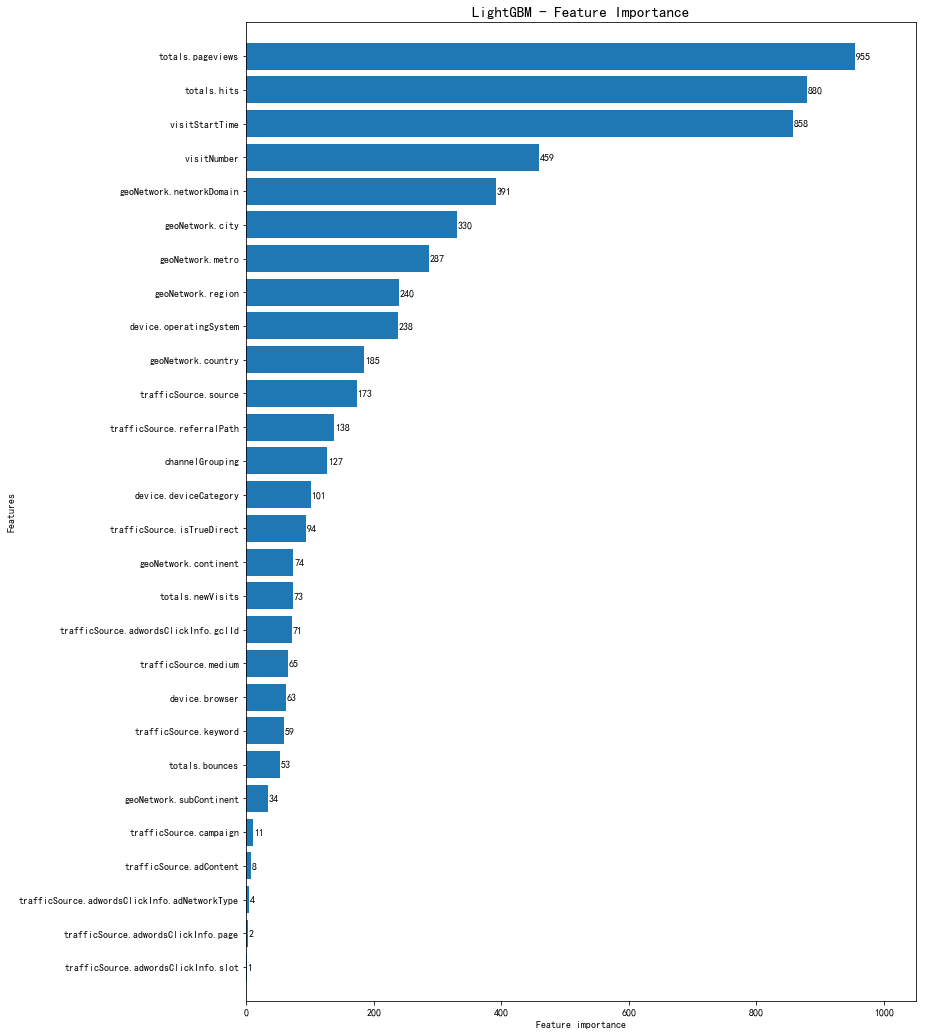

In [78]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

# 修改模型

### 模型修改

In [157]:
train_df.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,sess_date_dow,sess_date_hours,sess_date_dom,sess_date_mon
0,4,2016-09-02,1131660440785968503,1472830385,1.0,2016-09-02 15:33:05,35,0,False,20,378,3,210,0,37454,193,21,1.0,1.0,1.0,1.0,0.0,62,3,59008,1,11,3,4,1,11,5,3196,208,4,21,3,3
1,4,2016-09-02,377306020877927890,1472880147,1.0,2016-09-03 05:22:27,43,0,False,7,955,5,12,122,10098,482,1,1.0,1.0,1.0,1.0,0.0,62,3,59008,1,11,3,4,1,11,5,3196,208,5,11,15,3
2,4,2016-09-02,3895546263509774583,1472865386,1.0,2016-09-03 01:16:26,35,0,False,20,475,4,185,0,38725,99,19,1.0,1.0,1.0,1.0,0.0,62,3,59008,1,11,3,4,1,11,5,3196,208,5,1,15,3
3,4,2016-09-02,4763447161404445595,1472881213,1.0,2016-09-03 05:40:13,79,0,False,6,955,3,94,122,38725,482,16,1.0,1.0,1.0,1.0,0.0,62,3,59008,1,11,3,4,1,1607,5,3196,208,5,11,15,3
4,4,2016-09-02,27294437909732085,1472822600,2.0,2016-09-02 13:23:20,35,1,True,1,955,4,217,122,38725,482,13,1.0,1.0,NaN,1.0,0.0,62,3,59008,1,11,3,4,0,11,5,3196,208,4,19,3,3


#### 新增时间特征

In [160]:
new_cols = ["sess_date_dow","sess_date_hours",
           "sess_date_dom","sess_date_mon"]

#### 建立模型

__删除num列中visitStartTime列__

In [112]:
num_cols.remove('visitStartTime')

__增加新的分类列__

In [161]:
cat_cols

['channelGrouping',
 'device.browser',
 'device.deviceCategory',
 'device.operatingSystem',
 'geoNetwork.city',
 'geoNetwork.continent',
 'geoNetwork.country',
 'geoNetwork.metro',
 'geoNetwork.networkDomain',
 'geoNetwork.region',
 'geoNetwork.subContinent',
 'trafficSource.adContent',
 'trafficSource.adwordsClickInfo.adNetworkType',
 'trafficSource.adwordsClickInfo.gclId',
 'trafficSource.adwordsClickInfo.page',
 'trafficSource.adwordsClickInfo.slot',
 'trafficSource.campaign',
 'trafficSource.keyword',
 'trafficSource.medium',
 'trafficSource.referralPath',
 'trafficSource.source',
 'trafficSource.adwordsClickInfo.isVideoAd',
 'trafficSource.isTrueDirect']

In [162]:
new_cat_cols=cat_cols+new_cols 

In [163]:
# Split the train dataset into development and valid based on time 
dev_df = train_df[train_df['date']<=datetime.date(2017,5,31)]
val_df = train_df[train_df['date']>datetime.date(2017,5,31)]
dev_y = np.log1p(dev_df["totals.transactionRevenue"].values)
val_y = np.log1p(val_df["totals.transactionRevenue"].values)

dev_X = dev_df[new_cat_cols + num_cols] 
val_X = val_df[new_cat_cols + num_cols] 
test_X = test_df[new_cat_cols + num_cols] 

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: FutureWarning:

Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: FutureWarning:

Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.



In [168]:
# custom function to run light gbm model
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 31,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.6,
        "bagging_frequency" : 5,
        "bagging_seed" : 2016,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y

# Training the model #
pred_test, model, pred_val = run_lgb(dev_X, dev_y, val_X, val_y, test_X)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.70279
[200]	valid_0's rmse: 1.69869
Early stopping, best iteration is:
[181]	valid_0's rmse: 1.69799


In [169]:
pred_val[pred_val<0] = 0
val_pred_df = pd.DataFrame({"fullVisitorId":val_df["fullVisitorId"].values})
val_pred_df["transactionRevenue"] = val_df["totals.transactionRevenue"].values
val_pred_df["PredictedRevenue"] = np.expm1(pred_val)

In [170]:
val_pred_df = val_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))

1.732364997192728


#### 特征重要性

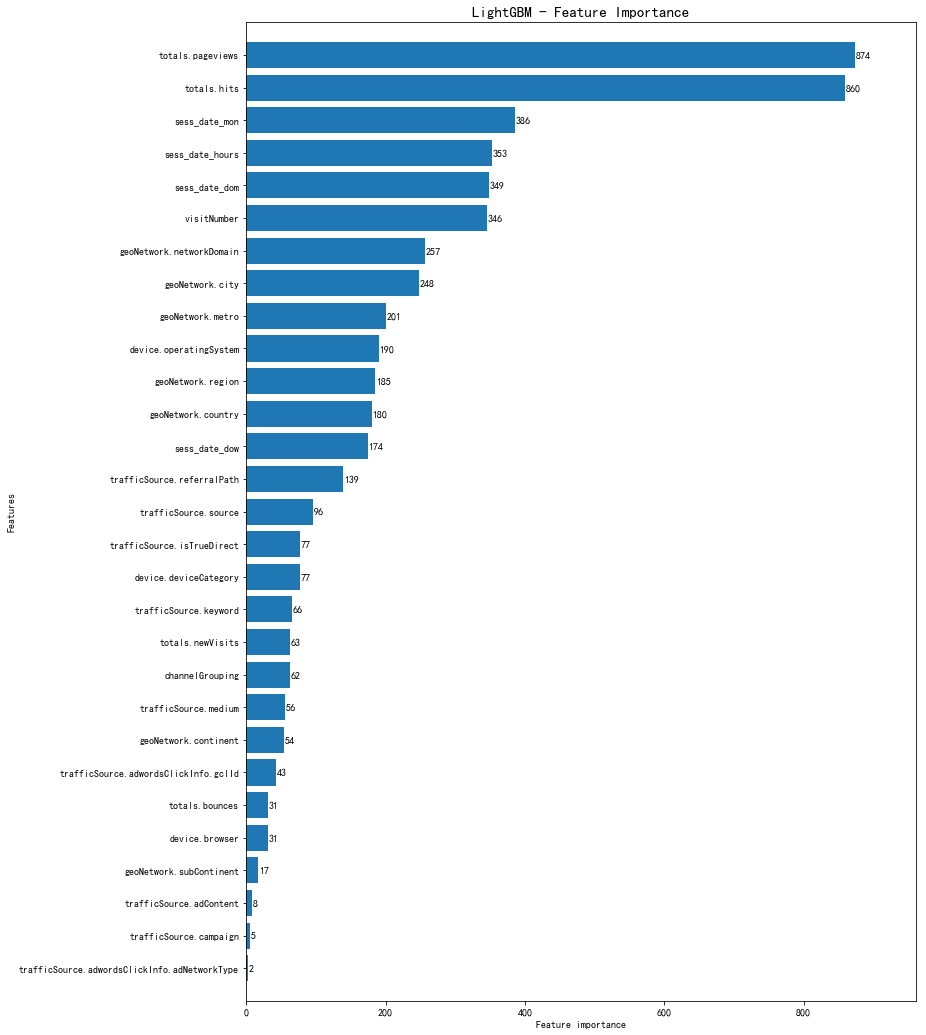

In [171]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

可以看出新的几个特征其重要性也还不错,LB准确率在1.46左右，反而下降了

# 提交数据集

In [172]:
sub_df = pd.DataFrame({"fullVisitorId":test_id})
pred_test[pred_test<0] = 0
sub_df["PredictedLogRevenue"] = np.expm1(pred_test)
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
sub_df.to_csv("F:\\kaggle\\GAR\\submission\\baseline_lgb.csv", index=False)

In [173]:
sub_df.head()

,fullVisitorId,PredictedLogRevenue
0,0000000259678714014,0.104750
1,0000049363351866189,0.000000
2,0000053049821714864,0.000000
3,0000059488412965267,0.028683
4,0000085840370633780,0.000000


In [174]:
sub_df.count()

fullVisitorId          617242
PredictedLogRevenue    617242
dtype: int64